baseline.ipynb <br>
.. ├ models <br>
.. └ data <br>
.... ├ train_sdf <br>
.... ├ dev_sdf <br>
.... ├ test_sdf <br>
.... ├ train_imgs <br>
.... ├ test_imgs <br>
.... ├ sample_train.csv <br>
.... ├ sample_test.csv <br>
.... └ sample_submission.csv <br>

## 사용 패키지

In [1]:
# !pip install rdkit-pypi

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
from tqdm import tqdm
import os

import torch
from torch import nn
from torchvision import models
from torch.utils.data import Dataset, DataLoader

In [3]:
os.getcwd()

'/home/chaeeun/Desktop/samsung_ai'

In [4]:
# print('numpy verison :', np.__version__)
# print('pandas version :', pd.__version__)
# print('opencv version :', cv2.__version__)
# print('rdkit version :', rdkit.__version__)
# print('torch version :', torch.__version__)

## 데이터 로드

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
train = pd.read_csv('./train.csv')
dev = pd.read_csv('./dev.csv')

In [7]:
train.head()

,uid,SMILES,S1_energy(eV),T1_energy(eV)
0,train_0,CCC1CCCCN1C(=O)C(C)OC(=O)c1c(C)oc(-n2cccc2)c1C#N,4.6747,3.3809
1,train_1,COc1ccc(Oc2ccc(N3C(=S)NC(c4ccccn4)C3c3cc(C)n(-...,3.6617,3.4585
2,train_2,CC(=O)Nc1ccc(C(=O)[C@H](C)Sc2nnc(C3CCCCC3)o2)cc1,3.6420,3.1787
3,train_3,OC(CNC1CC1)CN1CCc2sccc2C1,4.8901,3.7847
4,train_4,CCNC(CCCC(F)(F)F)C1(OCC)CCOCC1,6.4967,6.2724


In [8]:
dev.head()

,uid,SMILES,S1_energy(eV),T1_energy(eV)
0,dev_0,O=C1c2ccccc2C2(c3ccccc31)c1ccccc1N(c1ccc(-c3nc...,2.7609,2.7540
1,dev_1,Cc1cccc2c3ccccc3n(-c3ccc(-c4c(-c5ccccc5)c(C#N)...,3.0495,3.0163
2,dev_2,CC1(C)c2ccccc2-c2ccc(-c3c(F)c(F)c(-c4ccc5c(c4)...,2.8314,2.1412
3,dev_3,CC(C)(C)c1ccc2c(c1)B1c3cc(C(C)(C)C)ccc3Oc3cc(-...,3.1813,2.9424
4,dev_4,O=C1c2cc(-c3ccc4c(c3)c3ccccc3n4-c3ccccc3)ccc2S...,2.9559,2.7362


In [9]:
train = pd.concat([train, dev])

In [10]:
train

,uid,SMILES,S1_energy(eV),T1_energy(eV)
0,train_0,CCC1CCCCN1C(=O)C(C)OC(=O)c1c(C)oc(-n2cccc2)c1C#N,4.6747,3.3809
1,train_1,COc1ccc(Oc2ccc(N3C(=S)NC(c4ccccn4)C3c3cc(C)n(-...,3.6617,3.4585
2,train_2,CC(=O)Nc1ccc(C(=O)[C@H](C)Sc2nnc(C3CCCCC3)o2)cc1,3.6420,3.1787
3,train_3,OC(CNC1CC1)CN1CCc2sccc2C1,4.8901,3.7847
4,train_4,CCNC(CCCC(F)(F)F)C1(OCC)CCOCC1,6.4967,6.2724
...,...,...,...,...
66,dev_66,N#Cc1cc(-c2ccc(N3c4ccccc4Oc4ccccc43)cc2)c(-c2c...,2.1939,2.1846
67,dev_67,CC1(C)c2ccccc2N(c2ccc(-c3nc4ccc(N5c6ccccc6C(C)...,2.3537,2.3371
68,dev_68,Cc1cc(-n2c3ccc(C(C)(C)C)cc3c3cc(C(C)(C)C)ccc32...,2.1364,2.1260
69,dev_69,Cc1cc(-n2c3ccccc3c3ccccc32)cc(C)c1B1c2ccccc2B(...,2.2650,2.2511


In [11]:
train.SMILES

0      CCC1CCCCN1C(=O)C(C)OC(=O)c1c(C)oc(-n2cccc2)c1C#N
1     COc1ccc(Oc2ccc(N3C(=S)NC(c4ccccn4)C3c3cc(C)n(-...
2      CC(=O)Nc1ccc(C(=O)[C@H](C)Sc2nnc(C3CCCCC3)o2)cc1
3                             OC(CNC1CC1)CN1CCc2sccc2C1
4                        CCNC(CCCC(F)(F)F)C1(OCC)CCOCC1
                            ...                        
66    N#Cc1cc(-c2ccc(N3c4ccccc4Oc4ccccc43)cc2)c(-c2c...
67    CC1(C)c2ccccc2N(c2ccc(-c3nc4ccc(N5c6ccccc6C(C)...
68    Cc1cc(-n2c3ccc(C(C)(C)C)cc3c3cc(C(C)(C)C)ccc32...
69    Cc1cc(-n2c3ccccc3c3ccccc32)cc(C)c1B1c2ccccc2B(...
70    CC(C)(C)c1ccc2c(c1)c1cc(C(C)(C)C)ccc1n2-c1c(Cl...
Name: SMILES, Length: 30345, dtype: object

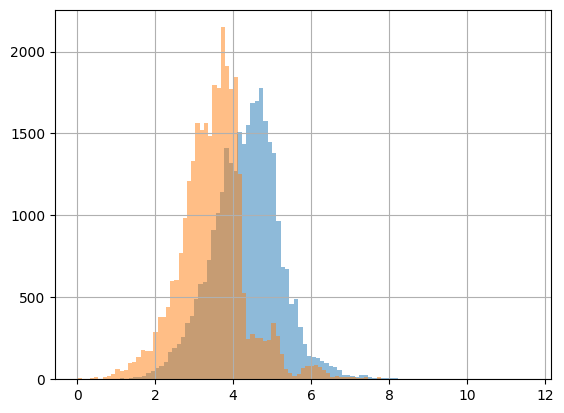

In [12]:
train['S1_energy(eV)'].hist(bins=100, alpha=0.5)
train['T1_energy(eV)'].hist(bins=100, alpha=0.5)
plt.show()

## 데이터 전처리

분자의 구조적 특성을 찾기 위해 SMILES와 분자구조 이미지를 사용하였습니다.

In [13]:
# for idx, row in tqdm(train.iterrows()):#행을 한줄씩 읽어들임
#     file = row['uid']#그 한줄에 있는 'uid'part을 file 에!
#     smiles = row['SMILES']
#     m = Chem.MolFromSmiles(smiles)
#     if m != None:
#         img = Draw.MolToImage(m, size=(300,300))
#         img.save(f'./train_imgs/{file}.png')

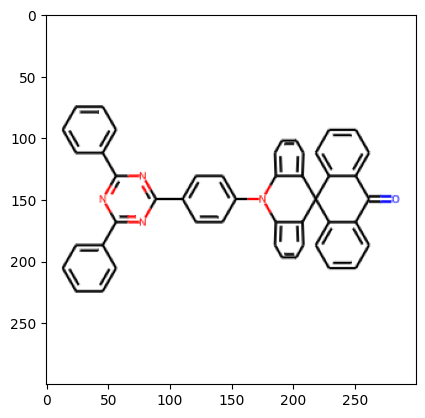

In [14]:
sample_img = cv2.imread('./train_imgs/dev_0.png')
plt.imshow(sample_img)
plt.show()

## 하이퍼파라미터

In [15]:
device = torch.device("cuda:0")
BATCH_SIZE = 64
EPOCHS = 30
num_layers = 3
dropout_rate = 0.1
embedding_dim = 128
learning_rate = 1e-3
vision_pretrain = True
save_path = f'./models/best_model.pt'

## SMILES Tokenizing

In [16]:
class SMILES_Tokenizer():
    def __init__(self, max_length):
        self.txt2idx = {}#dictionary
        self.idx2txt = {}#dictionary
        self.max_length = max_length
    
    def fit(self, SMILES_list):
        unique_char = set()#집합만들기
        for smiles in SMILES_list:#train.SMILES 분자식 리스트에서
            for char in smiles:#한 글자씩 뽑아서
                unique_char.add(char)#집합에 더해
        unique_char = sorted(list(unique_char))#집합을 리스트로 만든 다음 정렬!
        for i, char in enumerate(unique_char):#하나씩 뽑아서
            self.txt2idx[char]=i+2#얘네가 목적
            self.idx2txt[i+2]=char#얘도
            
    def txt2seq(self, texts):#texts: 또 train.SMILES가 드감.
        seqs = []#리스트
        for text in tqdm(texts):#train.SMILES에서 한 줄씩 읽어서
            seq = [0]*self.max_length#일단 seq는 0으로 이루어진 리스트이고
            for i, t in enumerate(text):#아까 읽어들인 한 줄의 글자들을 순서대로 읽는데
                if i == self.max_length:#만약 길이가 제일 긴거고 긴거의 마지막 글자면 반복문 나가
                    break
                try:#그게 아니면 seq에 글자의 순서위치에 글자가 가리키는 인덱스가 들어갈겨.
                    seq[i] = self.txt2idx[t]
                except:#없...으면? 1??
                    seq[i] = 1
            seqs.append(seq)
        return np.array(seqs)#[...[], [], [], ...]

In [17]:
max_len = train.SMILES.str.len().max()#가장 길이가 긴 것은?
max_len

265

In [18]:
tokenizer = SMILES_Tokenizer(max_len)
tokenizer.fit(train.SMILES)#txt2idx, idx2txt 딕셔너리 생성됨. 모든 character에 대한 집합을 인덱스와 함께 딕셔너리로 저장

In [19]:
seqs = tokenizer.txt2seq(train.SMILES)
labels = train[['S1_energy(eV)', 'T1_energy(eV)']].to_numpy()#이것이 정답이군
imgs = ('./train_imgs/'+train.uid+'.png').to_numpy()#input

100%|██████████| 30345/30345 [00:00<00:00, 43775.63it/s]


In [20]:
labels.shape

(30345, 2)

## 학습 데이터셋

In [21]:
from sklearn.utils import shuffle
imgs, seqs, labels = shuffle(imgs, seqs, labels, random_state=42)#아마 순서를 다 짝지은 상태에서 흔들어주는거겟지...?

In [22]:
train_imgs = imgs[:27000]
train_seqs = seqs[:27000]
train_labels = labels[:27000]
val_imgs = imgs[27000:]
val_seqs = seqs[27000:]
val_labels = labels[27000:]

In [23]:
train_imgs.shape, train_seqs.shape, train_labels.shape, val_imgs.shape, val_seqs.shape, val_labels.shape

((27000,), (27000, 265), (27000, 2), (3345,), (3345, 265), (3345, 2))

In [24]:
class CustomDataset(Dataset):
    def __init__(self, imgs, seqs, labels=None, mode='train'):
        self.mode = mode
        self.imgs = imgs
        self.seqs = seqs
        if self.mode=='train':
            self.labels = labels
            
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, i):
        img = cv2.imread(self.imgs[i]).astype(np.float32)/255
        img = np.transpose(img, (2,0,1))
        if self.mode == 'train':
            return {
                'img' : torch.tensor(img, dtype=torch.float32),#이미지 정보 하나
                'seq' : torch.tensor(self.seqs[i], dtype=torch.long),#글 정보 하나, 분자식의 형태, 순서가 반영되어있는 정보
                'label' : torch.tensor(self.labels[i], dtype=torch.float32)
            }
        else:
            return {
                'img' : torch.tensor(img, dtype=torch.float32),
                'seq' : torch.tensor(self.seqs[i], dtype=torch.long),
            }

In [25]:
train_dataset = CustomDataset(train_imgs, train_seqs, train_labels)
val_dataset = CustomDataset(val_imgs, val_seqs, val_labels)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=16, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=16, shuffle=True)

In [26]:
sample_batch = next(iter(train_dataloader))#하나 뽑아볼까

In [27]:
sample_batch['img'].size(), sample_batch['seq'].size(), sample_batch['label'].size()

(torch.Size([64, 3, 300, 300]), torch.Size([64, 265]), torch.Size([64, 2]))

In [28]:
sample_batch['img'].dtype, sample_batch['seq'].dtype, sample_batch['label'].dtype

(torch.float32, torch.int64, torch.float32)

## 모델

ResNet50에 LSTM을 연결한 CNN2RNN 모델

In [29]:
class CNN_Encoder(nn.Module):
    def __init__(self, embedding_dim, rate):
        super(CNN_Encoder, self).__init__()#이게 머더라
        model = models.resnet50(pretrained=vision_pretrain)#모델 긁어와서
        modules = list(model.children())[:-2]
        self.feature_extract_model = nn.Sequential(*modules)
        self.dropout1 = nn.Dropout(rate)
        self.fc = nn.Linear(2048, embedding_dim)
        self.dropout2 = nn.Dropout(rate)
        
    def forward(self, x):
        x = self.feature_extract_model(x)
        x = x.permute(0,2,3,1)
        x = x.view(x.size(0), -1, x.size(3))
        x = self.dropout1(x)
        x = nn.ReLU()(self.fc(x))
        x = self.dropout2(x)
        return x

In [30]:
class RNN_Decoder(nn.Module):
    def __init__(self, max_len, embedding_dim, num_layers, rate):
        super(RNN_Decoder, self).__init__()
        self.embedding = nn.Embedding(max_len, embedding_dim)
        self.dropout = nn.Dropout(rate)
        self.lstm = nn.LSTM(embedding_dim, embedding_dim, num_layers)
        self.final_layer = nn.Linear((max_len+100)*embedding_dim, 2)

    def forward(self, enc_out, dec_inp):
        embedded = self.embedding(dec_inp)
        embedded = self.dropout(embedded)
        embedded = torch.cat([enc_out, embedded], dim=1)
        hidden, _ = self.lstm(embedded)#hidden 은 대충 output, _은 (cn,hn)머시긴데 필요없으니까 _
#         print(hidden.shape)
        hidden = hidden.view(hidden.size(0), -1)#
#         print(hidden.shape)
        output = nn.ReLU()(self.final_layer(hidden))
        return output

In [31]:
class CNN2RNN(nn.Module):
    def __init__(self, embedding_dim, max_len, num_layers, rate):
        super(CNN2RNN, self).__init__()
        self.cnn = CNN_Encoder(embedding_dim, rate)
        self.rnn = RNN_Decoder(max_len, embedding_dim, num_layers, rate)
        
    def forward(self, img, seq):
        cnn_output = self.cnn(img)
        output = self.rnn(cnn_output, seq)
        
        return output

In [32]:
model = CNN2RNN(embedding_dim=embedding_dim, max_len=max_len, num_layers=num_layers, rate=dropout_rate)
model = model.to(device)

## 학습 정의

In [33]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.L1Loss()

In [34]:
def train_step(batch_item, epoch, batch, training):
    img = batch_item['img'].to(device)
    seq = batch_item['seq'].to(device)
    label = batch_item['label'].to(device)
    if training is True:
        model.train()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(img, seq)
            loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        return loss
    else:
        model.eval()
        with torch.no_grad():
            output = model(img, seq)
            loss = criterion(output, label)
            
        return loss

## 학습

In [35]:
loss_plot, val_loss_plot = [], []

for epoch in range(EPOCHS):
    total_loss, total_val_loss = 0, 0
    
    tqdm_dataset = tqdm(enumerate(train_dataloader))
    training = True
    for batch, batch_item in tqdm_dataset:
        batch_loss = train_step(batch_item, epoch, batch, training)
        total_loss += batch_loss
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Loss': '{:06f}'.format(batch_loss.item()),
            'Total Loss' : '{:06f}'.format(total_loss/(batch+1))
        })
    loss_plot.append(total_loss/(batch+1))
    
    tqdm_dataset = tqdm(enumerate(val_dataloader))
    training = False
    for batch, batch_item in tqdm_dataset:
        batch_loss = train_step(batch_item, epoch, batch, training)
        total_val_loss += batch_loss
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Val Loss': '{:06f}'.format(batch_loss.item()),
            'Total Val Loss' : '{:06f}'.format(total_val_loss/(batch+1))
        })
    val_loss_plot.append(total_val_loss/(batch+1))
    
    if min(val_loss_plot) == val_loss_plot[-1]:#np.min(val_loss_plot) == val_loss_plot[-1]
        torch.save(model, save_path)

0it [00:00, ?it/s]/home/chaeeun/.conda/envs/sce/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
422it [01:49,  3.87it/s, Epoch=1, Loss=0.460403, Total Loss=1.737270]
53it [00:09,  5.84it/s, Epoch=1, Val Loss=0.909702, Total Val Loss=0.997196]
422it [01:47,  3.92it/s, Epoch=2, Loss=0.351100, Total Loss=0.434784]
53it [00:09,  5.83it/s, Epoch=2, Val Loss=0.904621, Total Val Loss=1.082905]
422it [01:46,  3.96it/s, Epoch=3, Loss=0.491619, Total Loss=0.413269]
53it [00:09,  5.84it/s, Epoch=3, Val Loss=0.838643, Total Val Loss=0.639692]
422it [01:51,  3.79it/s, Epoch=4, Loss=0.468817, Total Loss=0.396404]
53it [00:09,  5.37it/s, Epoch=4, Val Loss=0.5226

KeyboardInterrupt: 

In [33]:
val_loss_plot

[tensor(0.4495, device='cuda:0'),
 tensor(0.5943, device='cuda:0'),
 tensor(0.9088, device='cuda:0'),
 tensor(0.7516, device='cuda:0'),
 tensor(0.5468, device='cuda:0'),
 tensor(0.6211, device='cuda:0'),
 tensor(1.1323, device='cuda:0'),
 tensor(0.4776, device='cuda:0'),
 tensor(0.8215, device='cuda:0'),
 tensor(0.4571, device='cuda:0'),
 tensor(0.6775, device='cuda:0'),
 tensor(0.4362, device='cuda:0'),
 tensor(0.7156, device='cuda:0'),
 tensor(0.3567, device='cuda:0'),
 tensor(1.5664, device='cuda:0'),
 tensor(0.3909, device='cuda:0'),
 tensor(1.1709, device='cuda:0'),
 tensor(0.3646, device='cuda:0'),
 tensor(0.4178, device='cuda:0'),
 tensor(0.8242, device='cuda:0'),
 tensor(0.7548, device='cuda:0'),
 tensor(0.6177, device='cuda:0'),
 tensor(0.3997, device='cuda:0'),
 tensor(0.7016, device='cuda:0'),
 tensor(0.6229, device='cuda:0'),
 tensor(0.5826, device='cuda:0'),
 tensor(0.4250, device='cuda:0'),
 tensor(0.6713, device='cuda:0'),
 tensor(0.6291, device='cuda:0'),
 tensor(0.6160

## 학습 결과

In [34]:
# plt.plot(loss_plot, label='train_loss')
# plt.plot(val_loss_plot, label='val_loss')
# plt.xlabel('epoch')
# plt.ylabel('loss(mae)')
# plt.legend()
# plt.show()

## 모델 복원

In [35]:
model = torch.load(save_path)

## 테스트 데이터 및 제출 양식 로드

In [36]:
test = pd.read_csv('./test.csv')
submission = pd.read_csv('./sample_submission.csv')

## 테스트 데이터 전처리

In [37]:
# for idx, row in tqdm(test.iterrows()):
#     file = row['uid']
#     smiles = row['SMILES']
#     m = Chem.MolFromSmiles(smiles)
#     if m != None:
#         img = Draw.MolToImage(m, size=(300,300))
#         img.save(f'./test_imgs/{file}.png')

## 테스트 데이터셋

In [38]:
test_seqs = tokenizer.txt2seq(test.SMILES)
test_imgs = ('./test_imgs/'+test.uid+'.png').to_numpy()

100%|██████████| 602/602 [00:00<00:00, 41598.23it/s]


In [39]:
test_dataset = CustomDataset(imgs=test_imgs, seqs=test_seqs, labels=None, mode='test')
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=16)

## 추론 및 제출

In [40]:
def predict(dataset):
    model.eval()
    result = []
    for batch_item in dataset:
        img = batch_item['img'].to(device)
        seq = batch_item['seq'].to(device)
        with torch.no_grad():
            output = model(img, seq)
        output = output.cpu().numpy()
        gap = output[:, 0] - output[:, 1]
        gap = np.where(gap<0, 0, gap)
        result.extend(list(gap))
        
    return result

In [41]:
pred = predict(test_dataloader)

In [42]:
submission['ST1_GAP(eV)'] = pred

In [43]:
submission

,uid,ST1_GAP(eV)
0,test_0,0.879373
1,test_1,0.960755
2,test_2,0.909495
3,test_3,0.628207
4,test_4,0.556311
...,...,...
597,test_597,0.540347
598,test_598,0.592062
599,test_599,0.876812
600,test_600,0.950485


In [44]:
submission.to_csv('dacon_baseline.csv', index=False)

제출 API 사용법 => https://dacon.io/forum/403557

In [45]:
# !pip install dacon_submit_api-0.0.4-py3-none-any.whl

In [46]:
from dacon_submit_api import dacon_submit_api 

result = dacon_submit_api.post_submission_file(
    'dacon_baseline.csv', 
    '2c85d68c97fb6955c823e742cddacea09d4b3a28f3ea41a15df46950f3656515', 
    '235789', 
    '픽미픽미픽미업', 
    'DACON_1'
)

{'isSubmitted': True, 'detail': 'Success'}


# Public LB Score : 0.1871130054